## Multinomial Logistic Regression

### Autor: Antonio Castañares Rodríguez

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter("ignore")

### Multinomial Logistic Regression

Logistic regression is a classification algorithm that models the relationship between features and the probability of a particular outcome. Unlike linear regression, which predicts continuous values, logistic regression applies a transformation to ensure predictions fall within the range (0,1). 

For binary classification, this is achieved using the sigmoid function:
$$
\sigma(z) = \frac{1}{1+e^{-z}}
$$

However, for multinomial classification, the softmax function is used to map real-valued numbers into a probability distribution over multiple classes:

$$
P(y = k | X) = \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}}
$$

Where:
- $z = Xw$ is a linear transformation of input features.
- $X$ is the feature matrix.
- $W$ is the weight matrix to be estimated.
- $z_k$ is the raw score for class $k$.
- $K$ is the total number of classes.

### Prediction Rule

Multinomial Logistic Regression is a discriminative model, meaning it predicts the most probable class:

$$
\hat{y} = \arg\max_k P(y = k)
$$

Where:
- $\hat{y}$ is the predicted class.
- $k$ is an index over all possible classes.

### **Loss Function**
The model is trained by minimizing the cross-entropy loss:

$$
J(W) = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y_{i,k} \log P(y = k | x_i)
$$

Where:
- $m$ is the number of training examples.
- $K$ is the total number of classes.
- $y_{i,k}$ is the true label (one-hot encoded) for sample $i$ and class $k$.
- $P(y = k | x_i)$ is the predicted probability that sample $i$ belongs to class $k$ given the feature vector $x_i$.

#### **Vectorized Form**
$$
J(W) = -\frac{1}{m} Y^T \log(\hat{Y})
$$

### **Gradient Descent Update**
To optimize the weights, we compute the gradient of the loss function:

$$
\frac{\partial{J}}{\partial{W}} = \frac{1}{m} X^T (\hat{Y} - Y)
$$

Where:
- $m$ is the number of samples.
- $X$ is the matrix of features.
- $Y$ is the one-hot encoded matrix of true labels.
- $\hat{Y} is the matrix of predicted probabilities from the softmax function.

We update the weights using gradient descent:

$$
W = W - \alpha \frac{\partial{J}}{\partial{W}}
$$

where $\alpha$ is the learning rate.




In [ ]:
class MultinomialLogisticRegression():
    def __init__(self):
        self.classes = None
        self.w = None

    def softmax(self, X):
        z = np.dot(X, self.w)                                        # (n_samples, n_features + 1) * (n_features + 1, n_classes) = (n_samples, n_classes)
        z -= np.max(z, axis=1, keepdims=True)                        # Avoid overflow
        # Softmax function e^z / sum(e^z)
        return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)  # (n_samples, n_classes)

    def fit(self, X, y, optimizer='gd', learning_rate=0.01, epochs=1000):

        # Dimensions
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        # Unique classes to map (use in predict method to map the result with the class) 
        self.classes = np.unique(y)                                 

        # Add bias term and initialize weights with zeros
        X = np.c_[np.ones((n_samples, 1)), X]                       # (n_samples, n_features + 1)
        self.w = np.zeros((n_features + 1, n_classes))              # (n_features + 1, n_classes)

        # One-hot encode y
        y_encoded = pd.get_dummies(y).values.astype(int)            # (n_samples, n_classes)

        for _ in range(epochs):
            result_softmax = self.softmax(X)                        # (n_samples, n_classes)    

            # gradient = 1/n_samples * X.T @ (prediction - y)
            gradient = 1/n_samples * np.dot(X.T, (result_softmax - y_encoded))    # (n_samples,n_features+1) @ ((n_features + 1, n_classes)

            if optimizer == 'gd':  # Gradient Descent
                self.w -= learning_rate * gradient                                # (escalar * (n_features + 1, n_classes)) = (n_features + 1, n_classes)

            else:  # Newton’s Method
                # Hessian diagonal = prediction * (1 - prediction) 
                D = np.diag((result_softmax * (1 - result_softmax)).sum(axis=1))  # (n_samples, n_samples)
                # Hessian = 1/n_samples * X.T @ D @ X
                hessian = 1/n_samples * np.dot(X.T, np.dot(D, X))                 # (n_features + 1, n_features + 1)
                # Newton Update: w = w - H^-1 @ gradient
                inverse_hessian = np.linalg.inv(hessian)                          
                self.w -= inverse_hessian @ gradient                              # (n_features + 1, n_classes)

        return self

    def predict(self, X):
        X = np.c_[np.ones((X.shape[0], 1)), X]                      # (n_samples, n_features + 1)
        result = np.argmax(self.softmax(X), axis=1)                 # Select the class with the highest probability (n_samples,)
        return self.classes[result]

In [3]:
# Input: y_test, y_pred, description
# Output: confusion matrix, accuracy, classification report
# Description: Print the confusion matrix, accuracy and classification report
def results(y_test,y_pred, description):
    plt.figure(figsize=(6,6))
    labels = ['3','4','5','6','7','8','9']
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix {description}')
    plt.show()

    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred, zero_division=0)}")

#### Wine Quality Dataset

The Wine Quality Dataset is a well-known dataset that contains physicochemical properties (e.g., acidity, sugar, pH) of different white wines and their corresponding quality scores. The dataset comes from Vinho Verde wines and was collected to study the relationship between chemical properties and perceived wine quality.

Each wine sample is labeled with a quality score (0-10), based on sensory evaluations by wine experts. The goal is to build a predictive model that can classify or predict wine quality based on its chemical composition.

Description of each feature: 
- Fixed Acidity: Concentration of non-volatile acids (e.g., tartaric acid), which contribute to the wine’s sour taste.
- Volatile Acidity: Concentration of volatile acids (mainly acetic acid), which can cause an unpleasant vinegar taste.
- Citric Acid: Natural acid found in wine that adds freshness and prevents oxidation.
- Residual Sugar: The amount of sugar left after fermentation; affects sweetness and body.
- Chlorides: The salt content in wine, which influences taste and stability.
- Free Sulfur Dioxide: SO₂ in its free state, acting as an antimicrobial and antioxidant agent.
- Total Sulfur Dioxide: The total SO₂ in wine (free + bound), used to preserve freshness and prevent spoilage.
- Density: The mass-to-volume ratio of wine, closely related to sugar and alcohol content.
- pH: The measure of wine’s acidity or alkalinity, impacting stability and taste.
- Sulphates: A sulfur-containing compound that enhances wine’s antimicrobial properties and adds to its crispness.
- Alcohol: The ethanol content in wine, affecting body, aroma, and quality perception.
- Quality (Target Variable): The sensory rating of wine, ranging from 0 to 10, given by wine tasters.

Let's import the dataset, rebuild the dataset and check their possible missing values.

In [4]:
df = pd.read_csv("winequality-white.csv")

In [5]:
df.head()

,"fixed acidity;""volatile acidity"";""citric acid"";""residual sugar"";""chlorides"";""free sulfur dioxide"";""total sulfur dioxide"";""density"";""pH"";""sulphates"";""alcohol"";""quality"""
0,7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6
1,6.3;0.3;0.34;1.6;0.049;14;132;0.994;3.3;0.49;9...
2,8.1;0.28;0.4;6.9;0.05;30;97;0.9951;3.26;0.44;1...
3,7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4...
4,7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4...


The dataset needs to be rebuilt because all data is merged into a single column, where each feature and its values are separated by ';'.

In [6]:
columns = [col.replace('"', '') for col in df.columns[0].split(';')] # Split the columns by ';' and remove quotes
values = [row[0].split(';') for row in df.values] # Split the values by ';'

# Create a new dataframe
df_wine = pd.DataFrame(values, columns=columns)

df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8,6
1,6.3,0.3,0.34,1.6,0.049,14,132,0.994,3.3,0.49,9.5,6
2,8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6


In [7]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   fixed acidity         4898 non-null   object
 1   volatile acidity      4898 non-null   object
 2   citric acid           4898 non-null   object
 3   residual sugar        4898 non-null   object
 4   chlorides             4898 non-null   object
 5   free sulfur dioxide   4898 non-null   object
 6   total sulfur dioxide  4898 non-null   object
 7   density               4898 non-null   object
 8   pH                    4898 non-null   object
 9   sulphates             4898 non-null   object
 10  alcohol               4898 non-null   object
 11  quality               4898 non-null   object
dtypes: object(12)
memory usage: 459.3+ KB


All features are type object. However, we need to transform them into float or int to use them in Logistic Regression

In [8]:
df_wine = df_wine.astype(float)
df_wine['quality'] = df_wine['quality'].astype(int)

In [9]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [10]:
print(f"Number of missing values\n{df_wine.isnull().sum()}")

Number of missing values
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


The dataset does not have missing values, however we need to change the type of each feature from object to float (as Logistic Regression needs numbers)

In [11]:
df_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


Each feature is expressed in different scales. Therefore, we need to use Standard Scaler to normalize them to the same scale. Furthermore, the quality ranges from 3 to 9.

In [12]:
scaler = StandardScaler()
df_wine_scaled = scaler.fit_transform(df_wine.drop('quality', axis=1))

df_wine_scaled = pd.DataFrame(df_wine_scaled, columns=df_wine.columns[:-1])
df_wine_scaled['quality'] = df_wine['quality']

Let's try to find relationships between features to identify which variables are most relevant for predicting 'quality' (target)

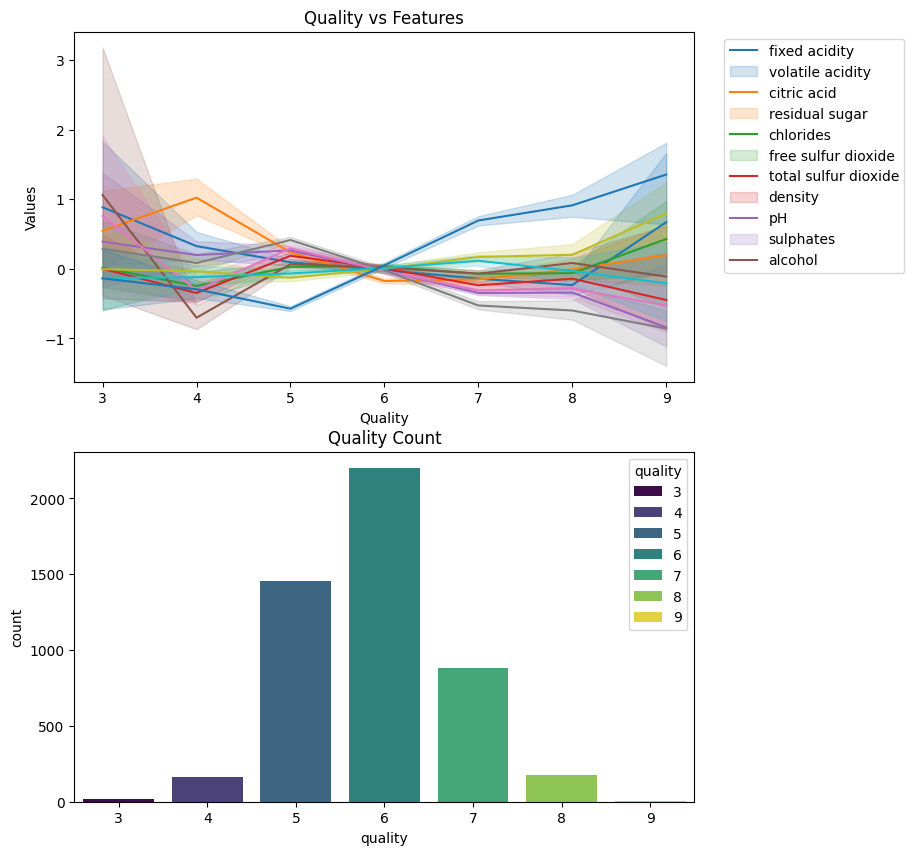

Percentage of wine quality:
quality
6    44.88
5    29.75
7    17.97
8     3.57
4     3.33
3     0.41
9     0.10
Name: proportion, dtype: float64


In [13]:
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
for i in df_wine.columns[:-1]: # Exclude the last column ('quality')
    sns.lineplot(x='quality', y=i, data=df_wine_scaled)
plt.title('Quality vs Features')
plt.xlabel('Quality')
plt.ylabel('Values')
plt.legend(['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides',
            'free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol'],
            loc='upper right', bbox_to_anchor=(1.35, 1))


plt.subplot(2,1,2)
sns.countplot(data=df_wine, x='quality', hue='quality', palette='viridis')
plt.title('Quality Count')
plt.show()

print(f'Percentage of wine quality:\n{(df_wine["quality"].value_counts(normalize=True) * 100).round(2)}')

Many lines are closely clustered, suggesting that most features do not show a strong direct relationship with wine quality.Futhermore, features like pH, density, and residual sugar do not show significant changes across different quality levels.

Finally, the dataset is imbalanced, as 44.88% of the samples belong to quality 6, and 29.75% belong to quality 5. This means that approximately 75.63% of the dataset falls into these two categories.

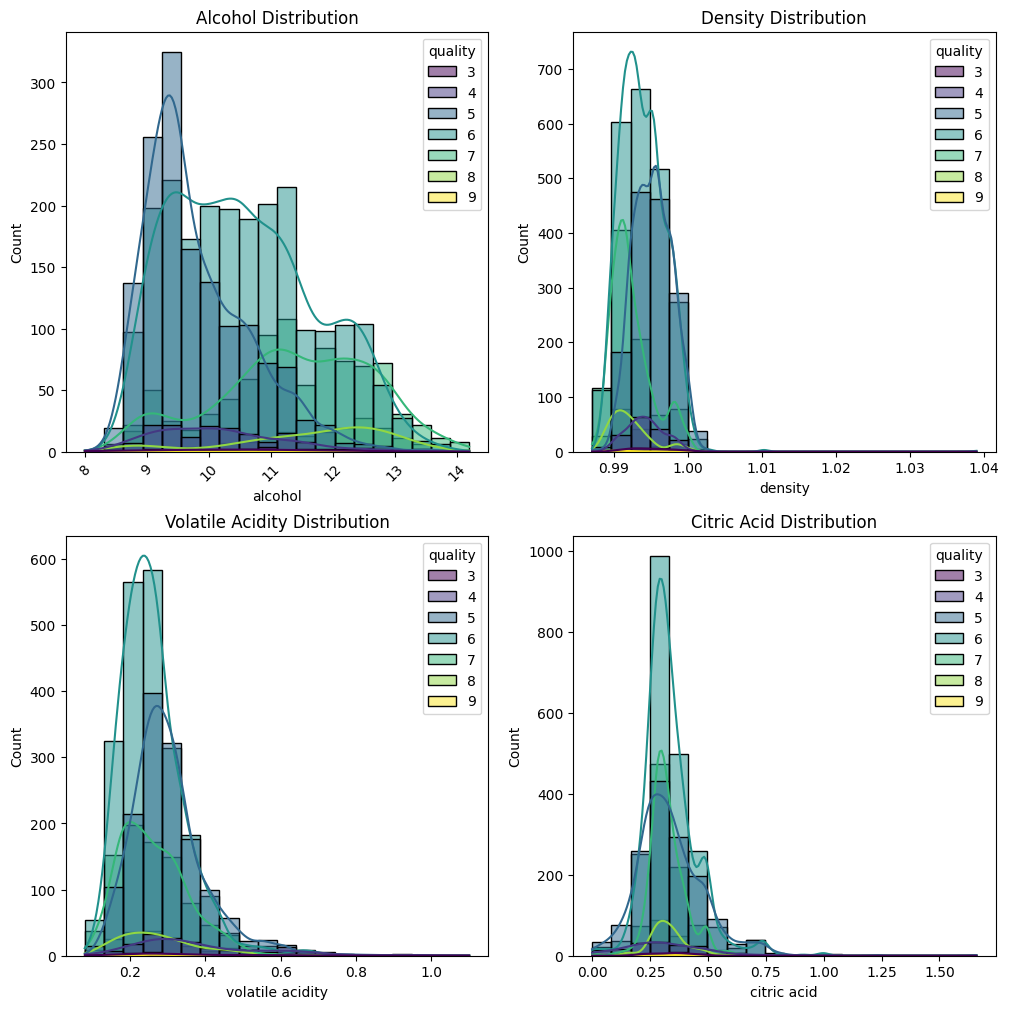

In [14]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.histplot(data=df_wine, x='alcohol', bins=20, kde=True, palette='viridis', hue='quality')
plt.xticks(rotation=45)
plt.title('Alcohol Distribution')
plt.subplot(2,2,2)
sns.histplot(data=df_wine, x='density', bins=20, kde=True, palette='viridis', hue='quality')
plt.title('Density Distribution')
plt.subplot(2,2,3) 
sns.histplot(data=df_wine, x='volatile acidity', bins=20, kde=True, palette='viridis', hue='quality')
plt.title('Volatile Acidity Distribution')
plt.subplot(2,2,4)
sns.histplot(data=df_wine, x='citric acid', bins=20, kde=True, palette='viridis', hue='quality')
plt.title('Citric Acid Distribution')
plt.show()

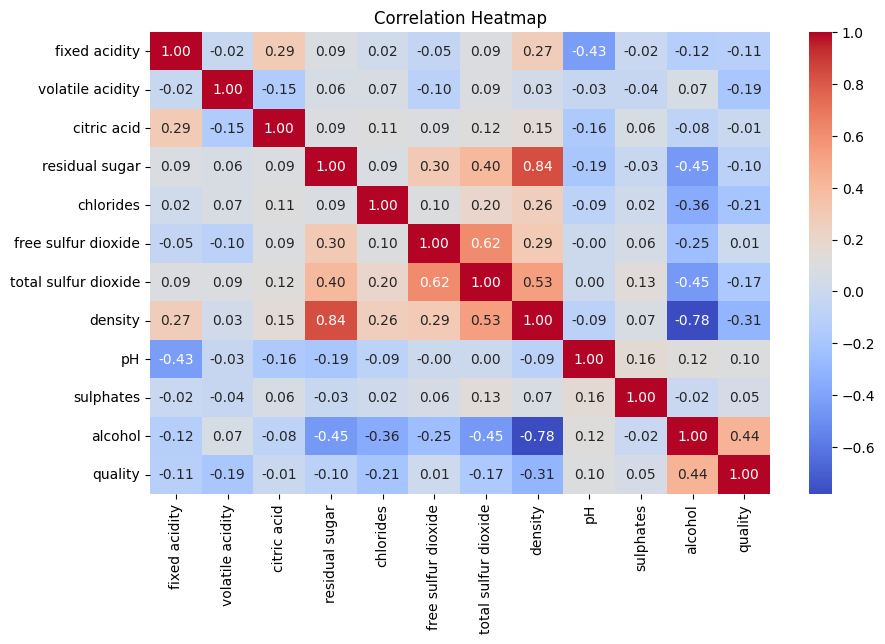

In [15]:
plt.figure(figsize=(10,6))
sns.heatmap(df_wine.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

The correlation heatmap reveals that alcohol content (0.44) is the strongest positive predictor of wine quality, while volatile acidity (-0.19), density (-0.31), and total sulfur dioxide (-0.17) negatively impact quality. Highly correlated features, such as density and residual sugar (0.84) or total and free sulfur dioxide (0.62), may introduce redundancy, suggesting that one of each pair could be removed or transformed. Fixed acidity, citric acid, chlorides, and sulphates show little correlation with quality, indicating they may have limited predictive value. 

#### Model training and results

Previously, I selected features such as 'alcohol', 'density', 'volatile acidity', and 'sulphates'. However, the results indicate that training the model with all features is necessary to achieve better performance. In this section, I will train my Logistic Regression model using two optimization approaches: Gradient Descent and Newton's Method. Finally, I will compare the results with those obtained using Sklearn.

In [16]:
selected_features = ['alcohol','density','volatile acidity','sulphates','total sulfur dioxide','chlorides','fixed acidity','residual sugar']

# X = df_wine[selected_features].values

X = df_wine.values

y = df_wine['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

Let's try to train my implementation using Gradient Descent.

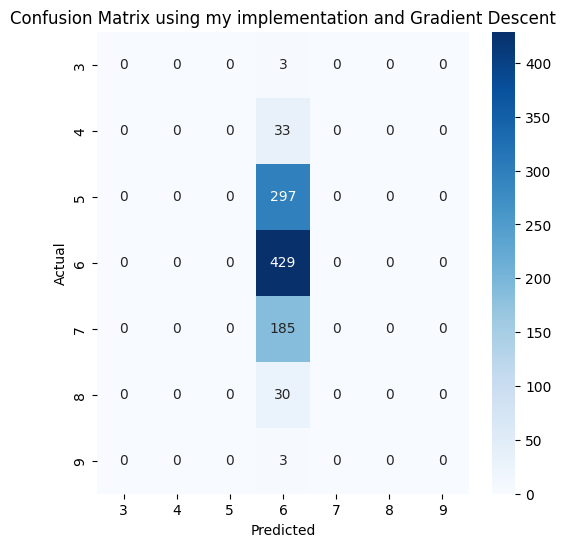

Accuracy: 0.4377551020408163
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        33
           5       0.00      0.00      0.00       297
           6       0.44      1.00      0.61       429
           7       0.00      0.00      0.00       185
           8       0.00      0.00      0.00        30
           9       0.00      0.00      0.00         3

    accuracy                           0.44       980
   macro avg       0.06      0.14      0.09       980
weighted avg       0.19      0.44      0.27       980



In [17]:
model = MultinomialLogisticRegression() # Gradient Descent by default
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

results(y_test, y_pred, 'using my implementation and Gradient Descent')

The results reveal that my implementation is biased toward class 5, as it always predicts this class. This issue occurs because the dataset is imbalanced, and Gradient Descent does not converge to the solution quickly. I decided to implement Newton's Method because it uses the Hessian matrix.

Unlike Gradient Descent, which only follows the gradient direction, Newton’s Method incorporates curvature information to take more accurate steps. It is important to note that while the negative gradient (first derivative) indicates the steepest descent direction, the second derivative (Hessian matrix) captures the curvature of the function. As a result, Newton’s Method typically converges in fewer iterations compared to Gradient Descent.

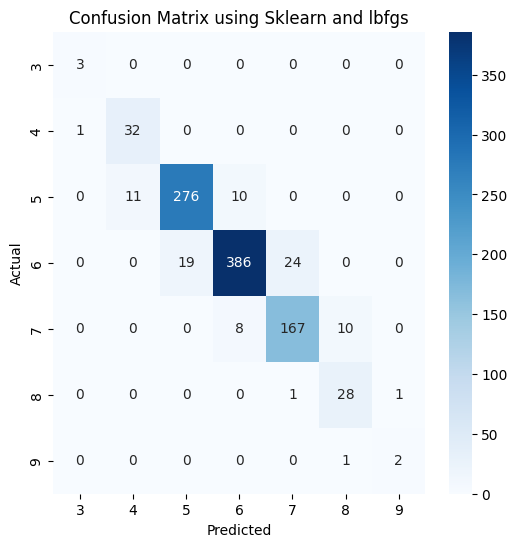

Accuracy: 0.9122448979591836
Classification Report:
              precision    recall  f1-score   support

           3       0.75      1.00      0.86         3
           4       0.74      0.97      0.84        33
           5       0.94      0.93      0.93       297
           6       0.96      0.90      0.93       429
           7       0.87      0.90      0.89       185
           8       0.72      0.93      0.81        30
           9       0.67      0.67      0.67         3

    accuracy                           0.91       980
   macro avg       0.81      0.90      0.85       980
weighted avg       0.92      0.91      0.91       980



In [18]:
model = LogisticRegression(class_weight="balanced", solver="lbfgs", max_iter=1000) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

results(y_test, y_pred, 'using Sklearn and lbfgs')

##### Newton's method

Newton’s method is an optimization technique that uses second-order derivative information (Hessian matrix) to find the minimum of a function. It is faster than gradient descent but computationally expensive.

Newton’s method approximates the loss function $L(w)$ using a quadratic function around the current weight $w_t$:

$$
L(w) \approx L(w_t) + \nabla L(w_t)^T (w - w_t) + \frac{1}{2} (w - w_t)^T \nabla^2 L(w_t) (w - w_t)
$$

where:

- $\nabla L(w_t)$ is the gradient (first derivative).
- $\nabla^2 L(w_t)$ is the Hessian matrix (second derivative).
- $w_t$ is the current parameter value.

Newton’s method finds the optimal step $\tilde{w}$ by setting the gradient to zero:

$$
\nabla L(w_t) + \nabla^2 L(w_t) (\tilde{w} - w_t) = 0
$$

Solving for $\tilde{w}$:

$$
w_{t+1} = w_t - \nabla^2 L(w_t)^{-1} \nabla L(w_t)
$$

where:

- $\nabla^2 L(w_t)^{-1}$ is the inverse Hessian matrix, which adjusts the step direction.
- $\nabla L(w_t)$ is the gradient (first derivative).

Therefore, we need to calculate the Hessian matrix which is the second derivative of the loss function:

$$
H = \frac{\partial^2 J}{\partial W^2}
$$

To compute this, we differentiate the gradient (https://stats.stackexchange.com/questions/68391/hessian-of-logistic-function):

$$
H = \frac{1}{m} X^T D X
$$

where:

- $D$ is diagonal matrix such that:

  $$
  D_i = \hat{y}(1 - \hat{y})
  $$

- $X$ is feature matrix that includes the bias.



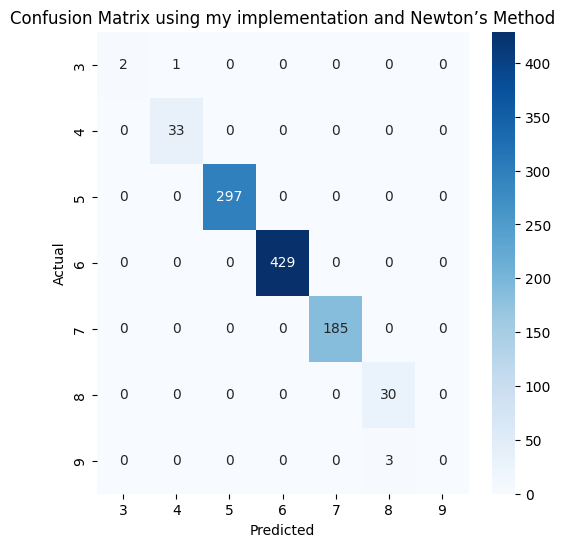

Accuracy: 0.9959183673469387
Classification Report:
              precision    recall  f1-score   support

           3       1.00      0.67      0.80         3
           4       0.97      1.00      0.99        33
           5       1.00      1.00      1.00       297
           6       1.00      1.00      1.00       429
           7       1.00      1.00      1.00       185
           8       0.91      1.00      0.95        30
           9       0.00      0.00      0.00         3

    accuracy                           1.00       980
   macro avg       0.84      0.81      0.82       980
weighted avg       0.99      1.00      0.99       980



In [19]:
model = MultinomialLogisticRegression()
model.fit(X_train, y_train, optimizer='newton')
y_pred = model.predict(X_test)

results(y_test, y_pred, 'using my implementation and Newton’s Method')

Newton’s Method achieves higher accuracy (99.59%) compared to Scikit-Learn’s implementation (91.22%). However, my implementation fails to predict class 9, as indicated by its precision, recall, and F1-score of 0, meaning it does not classify any samples as class 9. On the other hand, it classifies samples in classes 5, 6, and 7 perfectly. The performance of my implementation could be improved by addressing class imbalance, such as adding more samples from the minority class.